In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch


Adapt the code from this repo
https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


In [ ]:
batch_size = 64
img_size = 28
channels = 1
img_shape = (channels, img_size, img_size) # channel, img_size, img_size

cuda = True if torch.cuda.is_available() else False

# Loss weight for gradient penalty
lambda_gp = 10

lr = 0.0002
b1 = 0.5
b2 = 0.999

n_epochs = 20
latent_dim = 100
n_critic = 5
sample_interval = 400

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

In [ ]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        ".",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Test my WGAN with GP methods
https://github.com/juliecious/sinGAN_reload/blob/main/src/util.py

In [ ]:
def move_to_gpu_if_available(t):
    if torch.cuda.is_available():
        return t.to(torch.device('cuda'))
    else:  # use CPU
        return t.to(torch.device('cpu'))

def calculate_gradient_penalty(real_images, fake_images, discriminator, lambda_term=10):
    # generate a random number epsilon from a uniform distribution U[0,1]
    epsilon = torch.rand(1, 1).expand(real_images.size())
    epsilon = move_to_gpu_if_available(epsilon)

    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated = move_to_gpu_if_available(interpolated)
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    grad_outputs = torch.ones(prob_interpolated.size())

    # calculate gradients of probabilities w.r.t examples
    gradients = autograd.grad(outputs=prob_interpolated,
                              inputs=interpolated,
                              grad_outputs=move_to_gpu_if_available(grad_outputs),
                              create_graph=True,
                              retain_graph=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term

    return gradient_penalty

Training

In [ ]:
batches_done = 0
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = calculate_gradient_penalty(real_imgs.data, fake_imgs.data, discriminator)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done % sample_interval == 0:
                save_image(fake_imgs.data[:25], "%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += n_critic

[Epoch 0/20] [Batch 0/938] [D loss: 99.170403] [G loss: -0.008612]
[Epoch 0/20] [Batch 5/938] [D loss: 95.870010] [G loss: -0.017797]
[Epoch 0/20] [Batch 10/938] [D loss: 87.960251] [G loss: -0.067910]
[Epoch 0/20] [Batch 15/938] [D loss: 72.143600] [G loss: -0.241314]
[Epoch 0/20] [Batch 20/938] [D loss: 47.827030] [G loss: -0.676427]
[Epoch 0/20] [Batch 25/938] [D loss: 12.879059] [G loss: -1.611544]
[Epoch 0/20] [Batch 30/938] [D loss: -34.387756] [G loss: -3.260139]
[Epoch 0/20] [Batch 35/938] [D loss: -96.881149] [G loss: -6.012109]
[Epoch 0/20] [Batch 40/938] [D loss: -168.141602] [G loss: -10.847523]
[Epoch 0/20] [Batch 45/938] [D loss: -254.221924] [G loss: -18.192955]
[Epoch 0/20] [Batch 50/938] [D loss: -343.102997] [G loss: -27.913797]
[Epoch 0/20] [Batch 55/938] [D loss: -445.789154] [G loss: -42.588940]
[Epoch 0/20] [Batch 60/938] [D loss: -524.907837] [G loss: -60.923866]
[Epoch 0/20] [Batch 65/938] [D loss: -617.892273] [G loss: -88.610619]
[Epoch 0/20] [Batch 70/938] [D

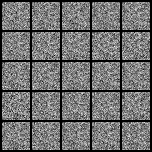

In [ ]:
from IPython.display import Image
Image('0.png')

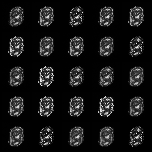

In [ ]:
Image('1600.png')

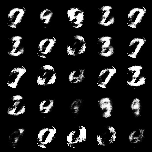

In [ ]:
Image('10000.png')

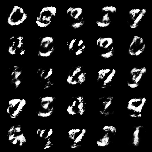

In [ ]:
Image('17600.png')